# Capacity analysis

## Introduction

demo of the Capacity analysis

In [12]:
%load_ext autoreload
%autoreload 2
# %autoreload?

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pandas as pd
from openenergyid.capacity import CapacityInput


## read in the sample data

In [14]:
with open('data/capacity/elec_sample2.json', 'r') as f:
# with open('data/capacity/electricity_delivered_sample.json', 'r') as f:

    input_data = CapacityInput.model_validate_json(f.read())
pd.DataFrame(input_data)

,0,1
0,timezone,Europe/Brussels
1,series,"index=[datetime.datetime(2024, 5, 31, 0, 15, t..."


In [15]:
# test = CapacityInput.data_frame(input_data)
elecSeries = input_data.get_series()
display(pd.DataFrame(elecSeries))

,0
2024-05-31 00:15:00+02:00,0.332
2024-05-31 00:30:00+02:00,0.292
2024-05-31 00:45:00+02:00,0.316
2024-05-31 01:00:00+02:00,0.316
2024-05-31 01:15:00+02:00,0.328
...,...
2024-07-02 22:45:00+02:00,1.184
2024-07-02 23:00:00+02:00,1.112
2024-07-02 23:15:00+02:00,1.056
2024-07-02 23:30:00+02:00,0.772


In [16]:
df_first_measurement = elecSeries.resample('D').first().to_frame(name='First Measurement')
print(len(df_first_measurement))

33


In [17]:
sorted_series = elecSeries.sort_values(ascending=False)
print(sorted_series)

2024-06-13 17:30:00+02:00    3.596
2024-06-13 17:45:00+02:00    3.316
2024-06-24 18:00:00+02:00    3.048
2024-06-06 00:15:00+02:00    2.888
2024-07-02 11:00:00+02:00    2.852
                             ...  
2024-06-24 09:00:00+02:00    0.260
2024-06-18 10:00:00+02:00    0.256
2024-06-20 16:15:00+02:00    0.256
2024-06-15 01:45:00+02:00    0.252
2024-06-03 12:30:00+02:00    0.244
Length: 3167, dtype: float64


## Analysis


In [18]:
from openenergyid.capacity.main import CapacityAnalysis

standard_month = CapacityAnalysis(input_data,threshold=0)
pd.DataFrame(standard_month.find_peaks(), columns=['peak_date', 'peak_value'])

,peak_date,peak_value
0,2024-05-31 19:15:00+02:00,2.320
1,2024-06-13 17:30:00+02:00,3.596
2,2024-07-02 11:00:00+02:00,2.852


In [19]:
analysis = CapacityAnalysis(input_data,threshold=0)
peaks = pd.DataFrame(analysis.find_peaks(), columns=['peak_date', 'peak_value'])

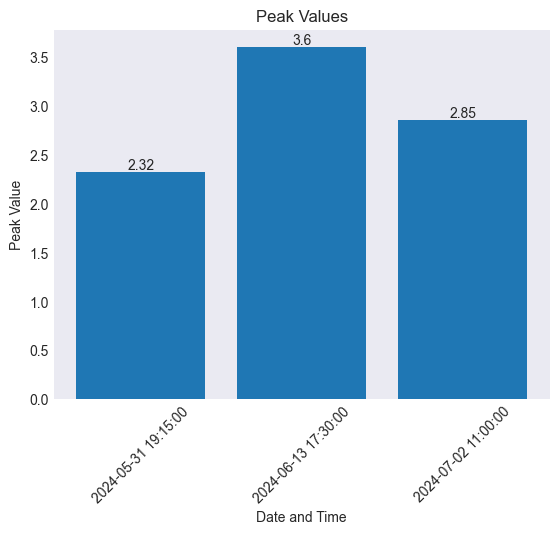

In [20]:
import matplotlib.pyplot as plt

# Convert the peak_date column to a nicely formatted string representation
peaks['peak_date'] = peaks['peak_date'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Plot the dataframe
bars = plt.bar(peaks['peak_date'], peaks['peak_value'])
plt.xlabel('Date and Time')
plt.ylabel('Peak Value')
plt.title('Peak Values')
plt.xticks(rotation=45)

# Adding the values to the top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

## Peak moments


## Sliding frame analysis
![Pasted image 20240628161500.png](<attachment:Pasted image 20240628161500.png>)
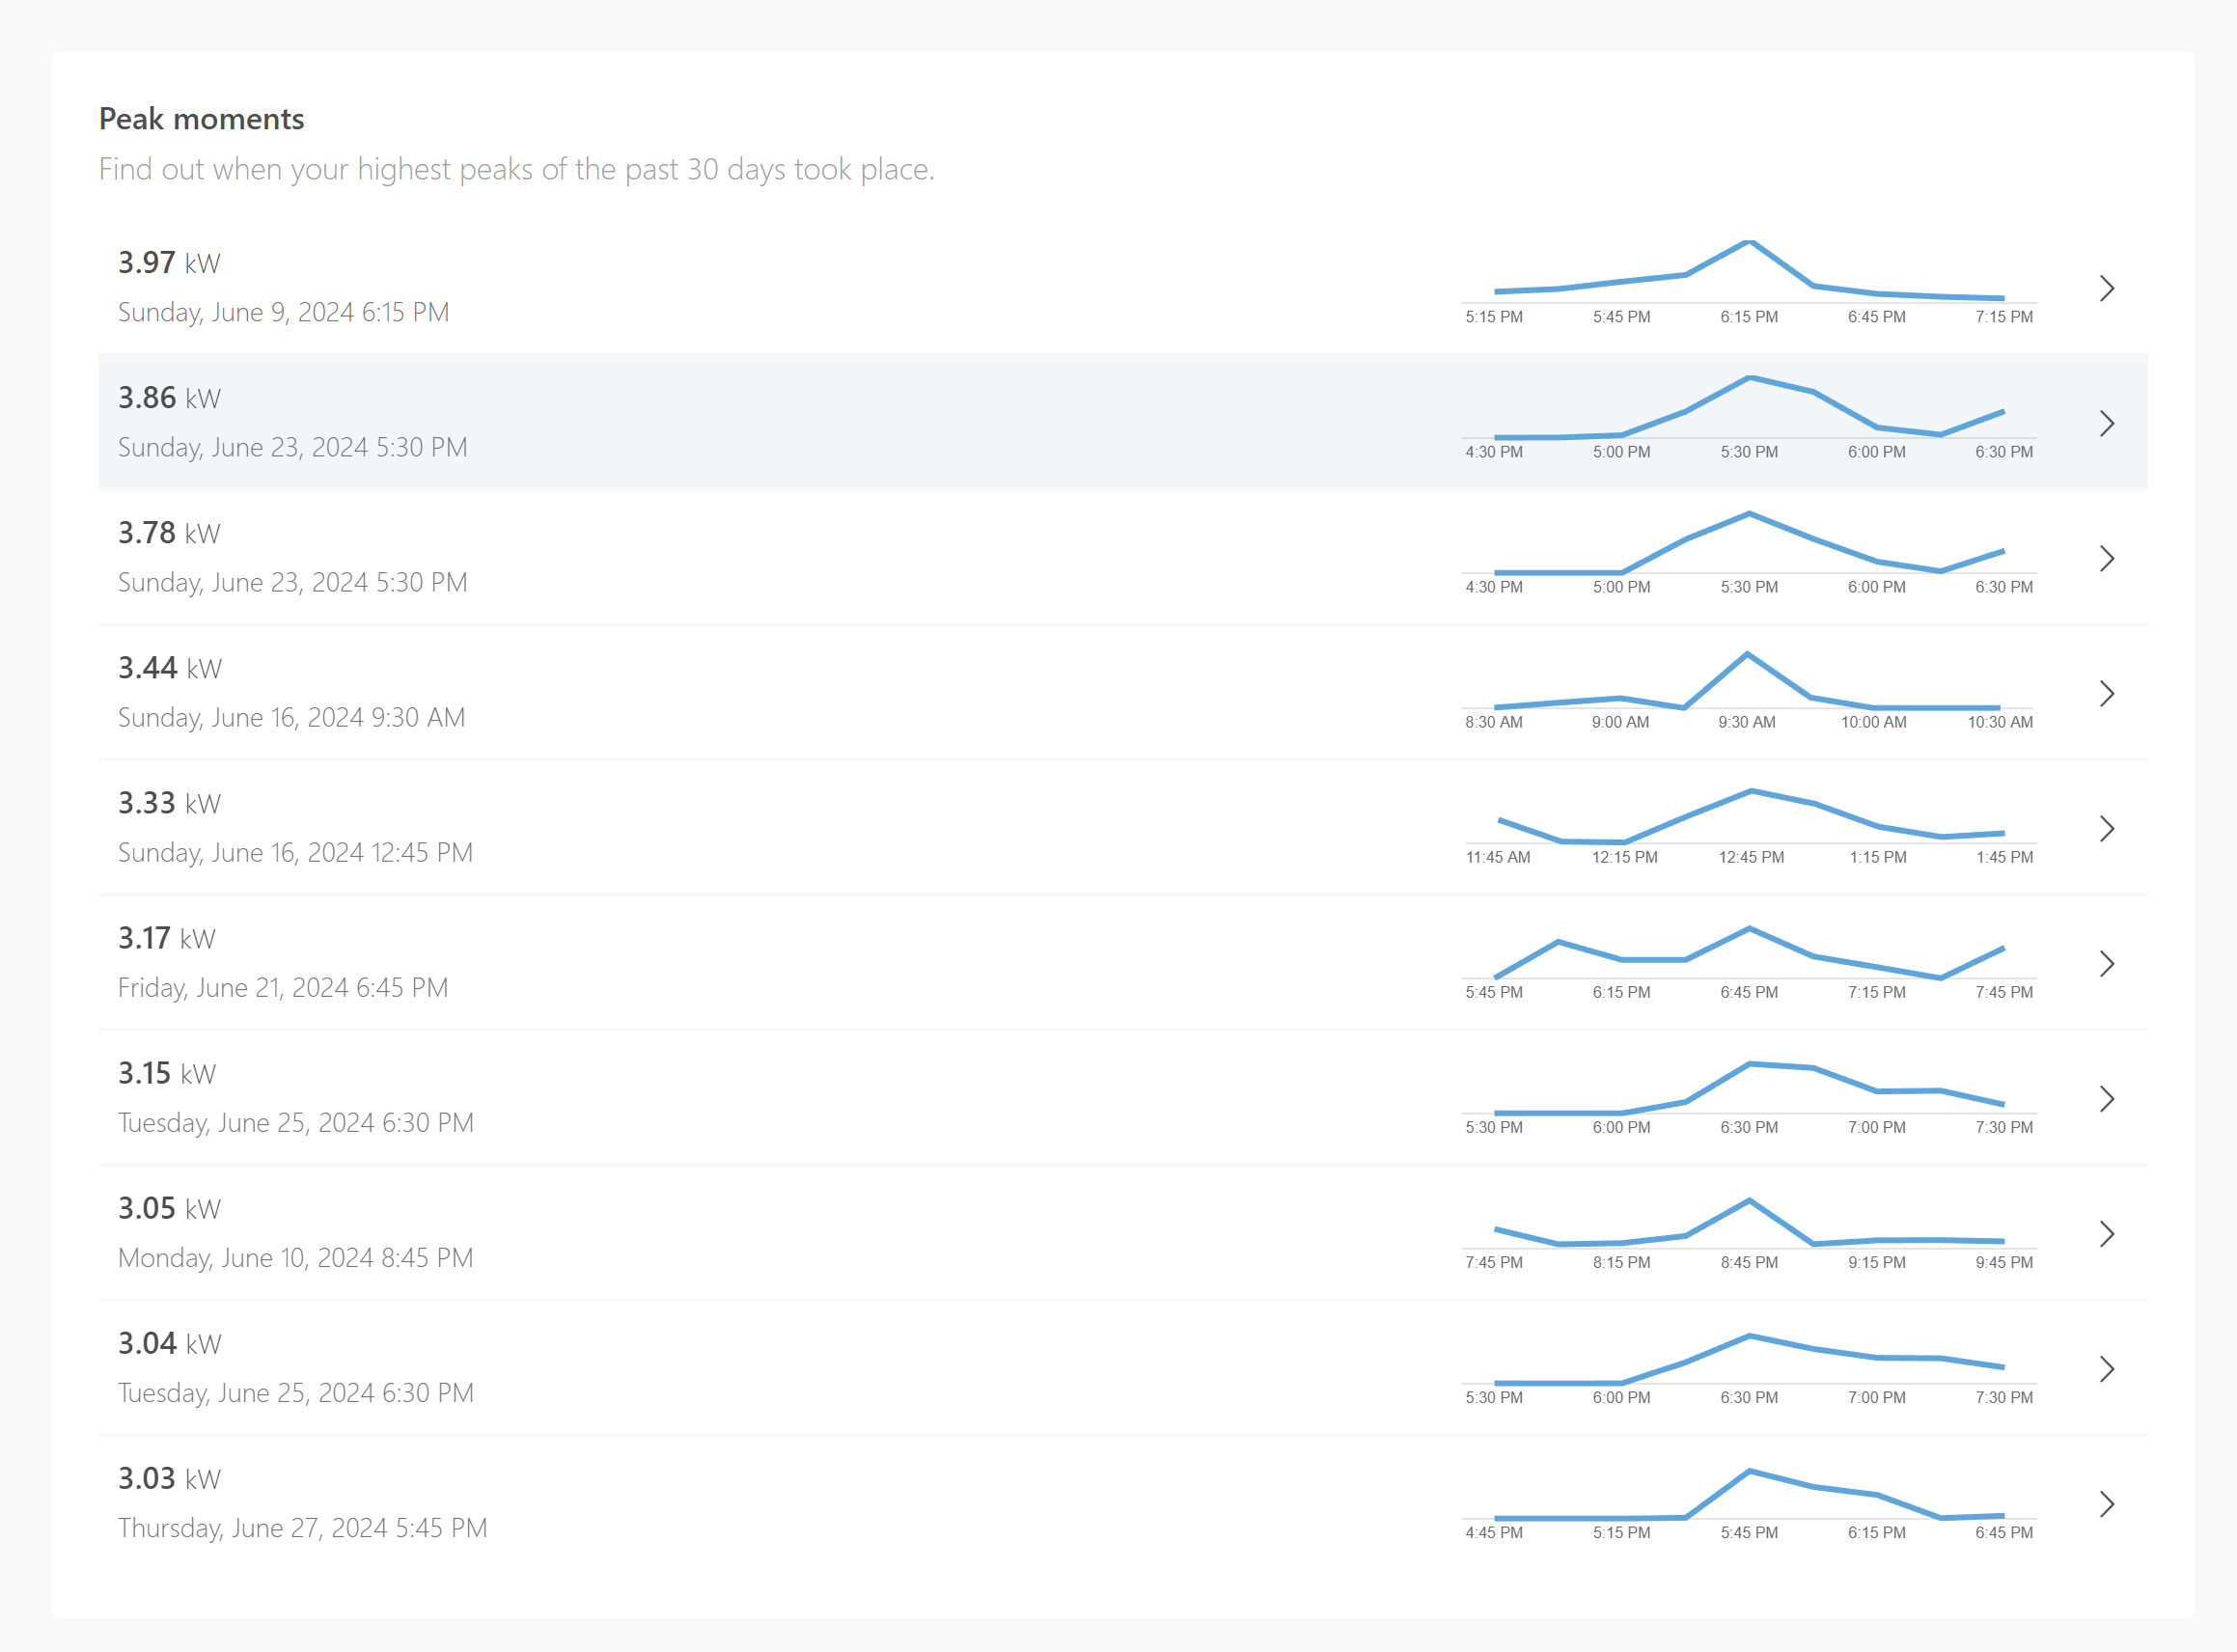

In [21]:
analysis = CapacityAnalysis(input_data, threshold=0)
pd.DataFrame(analysis.find_peaks(), columns=['peak_date', 'peak_value'])
data = analysis.find_peaks_with_surroundings()
display(data)
## TODO add return typed output object to the find_peaks_with_surroundings method
## TODO move properties used in the input model


[{'peak_time': '2024-06-13T17:30:00+02:00',
  'peak_value': 3.596,
  'surrounding_data': [{'timestamp': '2024-06-13T16:30:00+02:00',
    'value': 2.104},
   {'timestamp': '2024-06-13T16:45:00+02:00', 'value': 0.9},
   {'timestamp': '2024-06-13T17:00:00+02:00', 'value': 2.628},
   {'timestamp': '2024-06-13T17:15:00+02:00', 'value': 1.352},
   {'timestamp': '2024-06-13T17:30:00+02:00', 'value': 3.596},
   {'timestamp': '2024-06-13T17:45:00+02:00', 'value': 3.316},
   {'timestamp': '2024-06-13T18:00:00+02:00', 'value': 2.216},
   {'timestamp': '2024-06-13T18:15:00+02:00', 'value': 1.412},
   {'timestamp': '2024-06-13T18:30:00+02:00', 'value': 0.768},
   {'timestamp': '2024-06-13T18:45:00+02:00', 'value': 0.544}]},
 {'peak_time': '2024-06-24T18:00:00+02:00',
  'peak_value': 3.048,
  'surrounding_data': [{'timestamp': '2024-06-24T17:00:00+02:00',
    'value': 0.628},
   {'timestamp': '2024-06-24T17:15:00+02:00', 'value': 0.724},
   {'timestamp': '2024-06-24T17:30:00+02:00', 'value': 2.492},

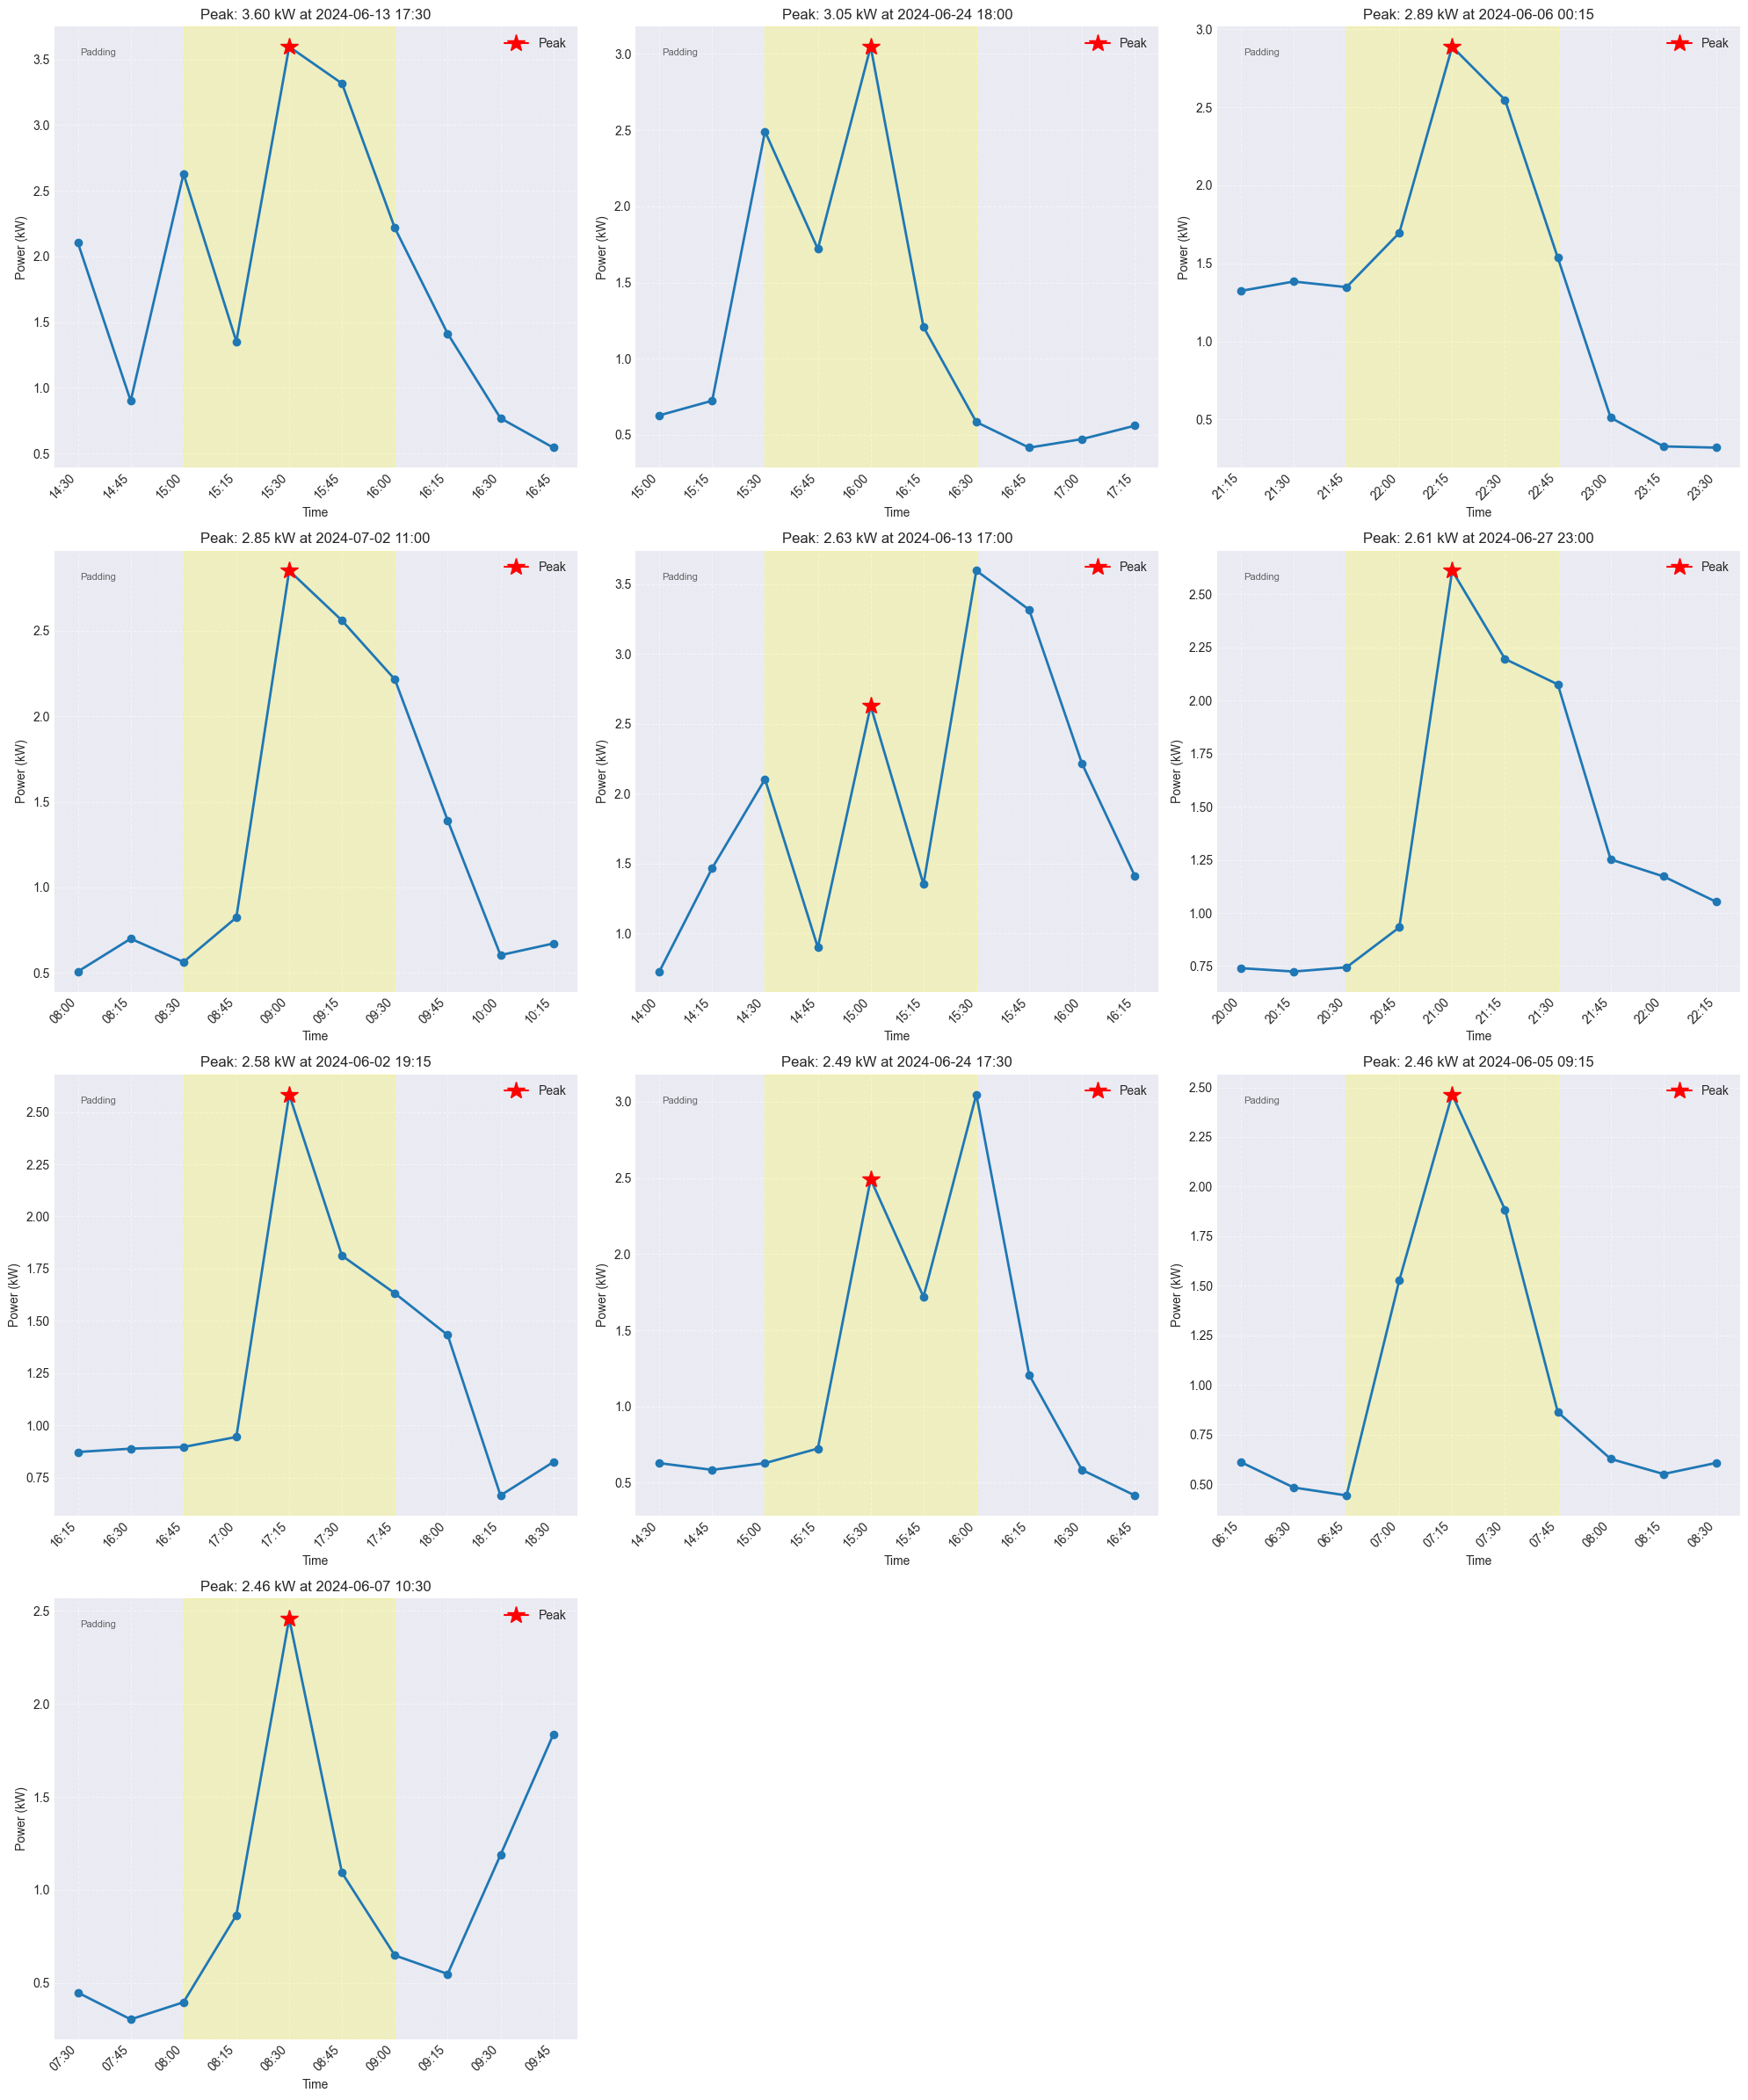

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import pytz

def plot_peaks(data):
    # Set up the plot style
    plt.style.use('seaborn-v0_8-dark')
    
    fig, axs = plt.subplots(4, 3, figsize=(20, 24))
    # fig.suptitle('Power Consumption Peaks', fontsize=16)

    axs = axs.flatten()

    for i, peak in enumerate(data):
        timestamps = [datetime.fromisoformat(point['timestamp']) for point in peak['surrounding_data']]
        values = [point['value'] for point in peak['surrounding_data']]
        peak_time = datetime.fromisoformat(peak['peak_time'])
        peak_value = peak['peak_value']

        ax = axs[i]
        ax.plot(timestamps, values, marker='o', linestyle='-', linewidth=2, markersize=6)
        ax.plot(peak_time, peak_value, marker='*', color='red', markersize=15, label='Peak')

        ax.set_title(f"Peak: {peak_value:.2f} kW at {peak_time.strftime('%Y-%m-%d %H:%M')}")
        ax.set_ylabel('Power (kW)')
        ax.set_xlabel('Time')

        # Set major locator for 15-minute intervals
        ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 15, 30, 45]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

        # Set minor locator for every minute
        ax.xaxis.set_minor_locator(mdates.MinuteLocator())

        # Customize grid
        ax.grid(True, which='major', linestyle='--', alpha=0.5)
        ax.grid(True, which='minor', linestyle=':', alpha=0.2)

        # Rotate and align the tick labels
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

        # Add legend
        ax.legend()

        # Highlight the padding area
        padding_minutes = 30  # Assuming 2 hours of padding (4 * 15 minutes on each side)
        start_padding = peak_time - timedelta(minutes=padding_minutes)
        end_padding = peak_time + timedelta(minutes=padding_minutes)
        ax.axvspan(start_padding, end_padding, color='yellow', alpha=0.2)

        # Add text to indicate padding
        ax.text(0.05, 0.95, 'Padding', transform=ax.transAxes, 
                verticalalignment='top', fontsize=8, alpha=0.7)

    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

# Assume the data is stored in a variable called 'data'


# Call the function to create the plots
plot_peaks(data)